# plotting

> Utils for plotting data


In [ ]:
# | default_exp core.plotting

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | export

from __future__ import annotations
from typing import Any

import math
import re
from collections import defaultdict
from enum import Enum, auto
from typing import Any, Callable

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import PIL.Image as PImg
from fastcore.test import test_fail
from ds_contrib.core.utils import tuplify
from ds_contrib.core.utils import dictify_with_names

In [ ]:
# | export
ImageLike = PImg.Image | np.ndarray

In [ ]:
# | export


def numpify_image(image: ImageLike) -> np.ndarray:
    """Numpify an image from PIL or numpy array.

    Parameters
    ----------
    image : PImg.Image | np.ndarray
        input image

    Returns
    -------
    np.ndarray
        image array

    Raises
    ------
    ValueError
        If the image is not PIL or numpy array.
    """
    if isinstance(image, PImg.Image):
        image = np.array(image)
    elif not isinstance(image, np.ndarray):
        raise ValueError(f"Unknown image type {type(image)}")
    return image

In [ ]:
# | export


def adjust_image(
    image: ImageLike, h: float = 1.0, s: float = 1.0, v: float = 1.0
) -> np.ndarray:
    """Adjust image brightness, saturation and hue.

    Parameters
    ----------
    im : np.ndarray
        input image
    h : float, optional
        hue value in range [0, 1], hue is a pure color, by default 1.0
    s : float, optional
        saturation value in range [0, 1], saturation is the intensity of the color, by default 1.0
    v : float, optional
        value value in range [0, 1], value is the brightness of the color, by default 1.0

    Returns
    -------
    np.ndarray
        image with adjusted brightness, saturation and hue
    """
    image = numpify_image(image)
    if h == 1 and s == 1 and v == 1:
        return image

    adj_im = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if h != 1:
        adj_im[..., 0] = adj_im[..., 0] * h
    if s != 1:
        adj_im[..., 1] = adj_im[..., 1] * s
    if v != 1:
        adj_im[..., 2] = adj_im[..., 2] * v
    adj_im = cv2.cvtColor(adj_im, cv2.COLOR_HSV2RGB)

    return adj_im

In [ ]:
# | export


class Color(Enum):
    RED = auto()
    BLUE = auto()
    GREEN = auto()
    YELLOW = auto()
    PURPLE = auto()
    ORANGE = auto()
    BLACK = auto()
    WHITE = auto()
    GRAY = auto()
    BROWN = auto()
    PINK = auto()
    CYAN = auto()
    LIME = auto()
    MAGENTA = auto()

    @property
    def rgb(self):
        if self == Color.RED:
            return (255, 0, 0)
        elif self == Color.BLUE:
            return (0, 0, 255)
        elif self == Color.GREEN:
            return (0, 255, 0)
        elif self == Color.YELLOW:
            return (255, 255, 0)
        elif self == Color.PURPLE:
            return (128, 0, 128)
        elif self == Color.ORANGE:
            return (255, 165, 0)
        elif self == Color.BLACK:
            return (0, 0, 0)
        elif self == Color.WHITE:
            return (255, 255, 255)
        elif self == Color.GRAY:
            return (128, 128, 128)
        elif self == Color.BROWN:
            return (165, 42, 42)
        elif self == Color.PINK:
            return (255, 192, 203)
        elif self == Color.CYAN:
            return (0, 255, 255)
        elif self == Color.LIME:
            return (210, 255, 0)
        elif self == Color.MAGENTA:
            return (255, 0, 255)
        else:
            raise ValueError(f"Unknown color {self}")

    @staticmethod
    def from_input(inp) -> tuple[int, int, int]:
        """Generate a tuple representation of a color from a variety of inputs.

        Parameters
        ----------
        inp : Colorifiable
            Input to convert to a tuple representation of a color, can be a Color, a string, a tuple of ints or single int.

        Returns
        -------
        tuple[int, int, int]
            RGB representation of the color

        Raises
        ------
        ValueError
            Arguments of input are not valid
        TypeError
            Type of input is not valid
        """
        if isinstance(inp, Color):
            return inp.rgb
        elif isinstance(inp, str):
            return Color[inp.upper()].rgb
        elif isinstance(inp, (tuple, int)):
            inp = tuplify(inp, 3)
            if len(inp) == 3:
                if all([0 <= c < 256 and isinstance(c, int) for c in inp]):
                    return inp
                else:
                    raise ValueError(
                        f"Tuple representation of color must have int values between 0 and 256, input={inp}"
                    )
            else:
                raise ValueError(
                    f"Tuple representation of color must have exactly 3 elements, len of input tuple={len(inp)}"
                )
        else:
            raise TypeError(f"Unknown input type {type(inp)}")


Colorifiable = Color | tuple[int, int, int]

In [ ]:
Color.RED.rgb

(255, 0, 0)

In [ ]:
Color.from_input("red")

(255, 0, 0)

In [ ]:
Color.from_input(inp=(255, 0, 0))

(255, 0, 0)

In [ ]:
Color.from_input(Color.RED)

(255, 0, 0)

In [ ]:
test_fail(
    lambda: Color.from_input((0.5, 0.5, 0.5)), contains="Tuple representation of color"
)

In [ ]:
# | export
def is_binary(mask: np.ndarray) -> bool:
    return mask.ndim == 2 and (
        mask.dtype == bool
        or (np.issubdtype(mask.dtype, np.unsignedinteger) and np.max(mask) <= 1)
    )

In [ ]:
# | export


def bin_mask_overlay(
    image: ImageLike,
    mask: np.ndarray,
    transparency: float = 0.5,
    mask_color: Colorifiable | None = None,
    dim: float = 0.0,
) -> np.ndarray:
    """Overlay a binary mask on an image with defined color and transparency.

    Parameters
    ----------
    image : np.ndarray

    mask : np.ndarray
        binary mask
    transparency : float, optional
        transparency of the mask, by default 0.5
    mask_color : Colorifiable | None, optional
        mask color, by default None
    dim : float, optional
        dim the background image, by default 0.0

    Returns
    -------
    np.ndarray
        image with overlayed mask
    """
    image = numpify_image(image)
    assert is_binary(
        mask
    ), f"Mask must be binary, but mask is dtype `{mask.dtype}` and shape `{mask.shape}`."
    inv_masked = np.zeros_like(image)

    inv_masked[mask == 0] = image[mask == 0]

    if mask_color is not None:
        # Color handling
        mask_color = Color.from_input(mask_color)

        masked = np.full_like(image, mask_color)
        masked = (
            image.astype(np.float32) * transparency
            + masked.astype(np.float32) * (1 - transparency)
        ) * np.expand_dims(mask == 1, -1)
        masked = masked.astype(np.uint8)
    else:
        masked = np.zeros_like(image)
        masked[mask == 1] = image[mask == 1]

    if dim > 0.0:
        inv_masked = adjust_image(inv_masked, v=(1 - dim))

    result = inv_masked + masked
    return result

In [ ]:
from pathlib import Path

In [ ]:
# | hide
image = Path("../assets/images/1108.png")
mask = Path("../assets/segmentations/1108.png")
image = PImg.open(image)
mask = np.array(PImg.open(mask))

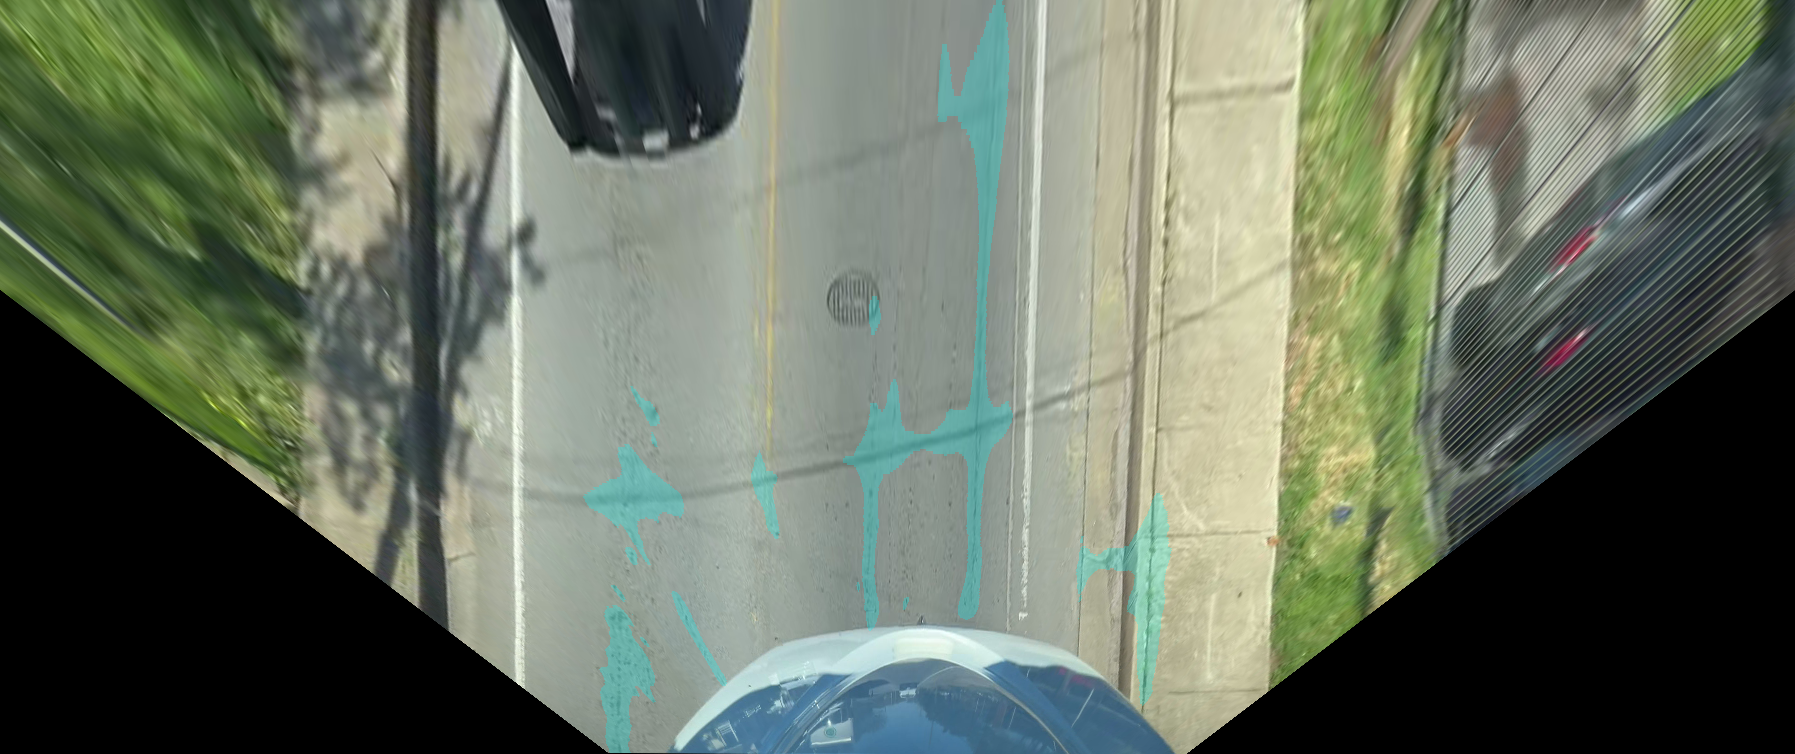

In [ ]:
PImg.fromarray(bin_mask_overlay(image, mask, mask_color=Color.CYAN, transparency=0.75))

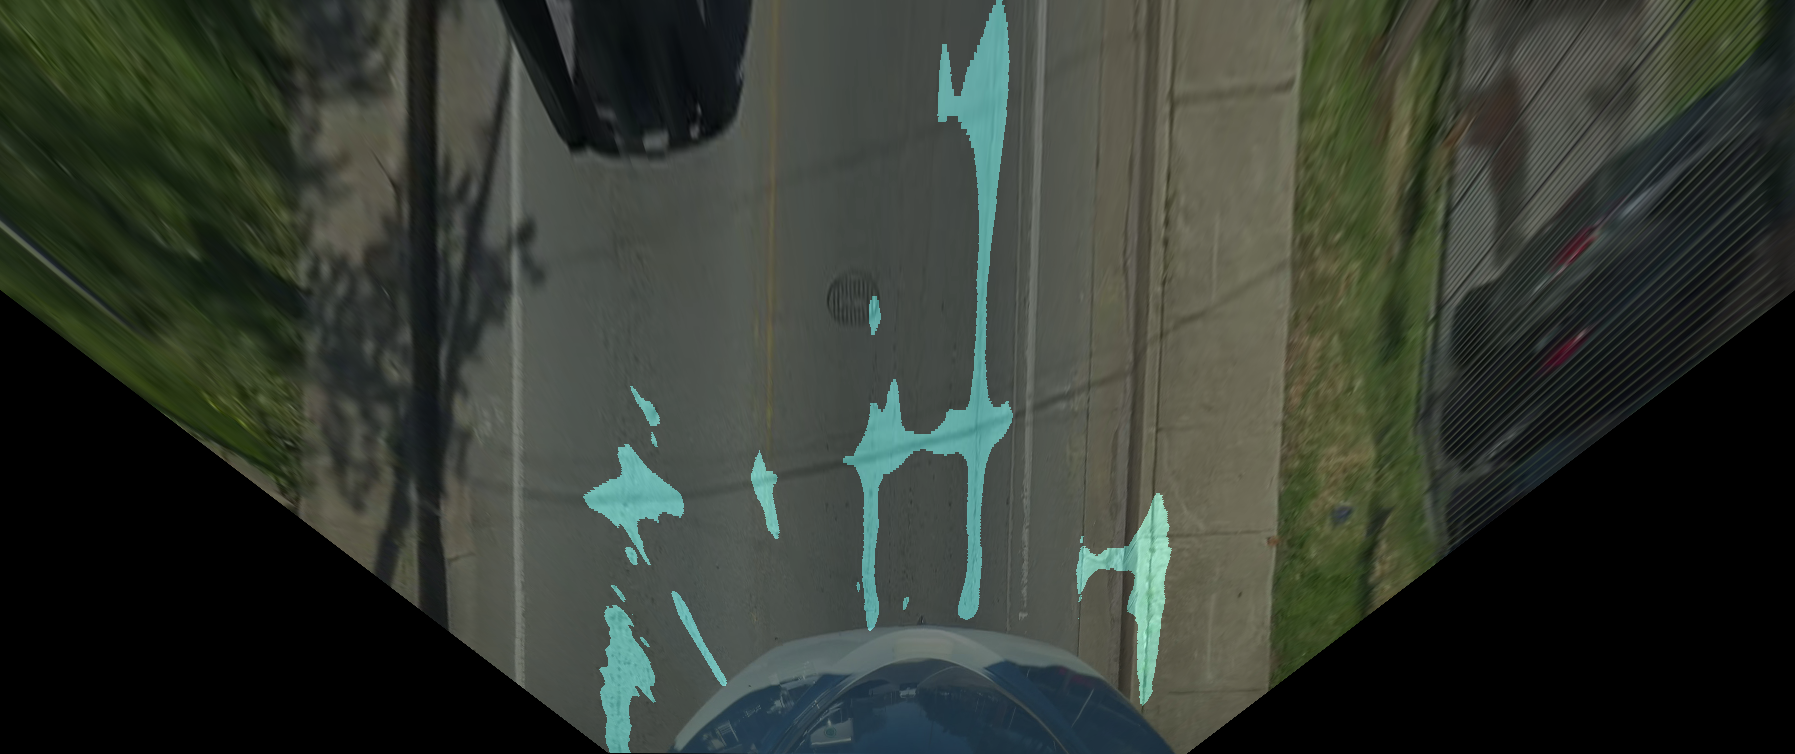

In [ ]:
PImg.fromarray(
    bin_mask_overlay(image, mask, mask_color=Color.CYAN, transparency=0.75, dim=0.5)
)

In [ ]:
# | hide
# | exporti


def logspace(array: np.ndarray, base=2):
    min_val = math.floor(np.emath.logn(base, np.min(array)))
    max_val = math.ceil(np.emath.logn(base, np.max(array)))
    # make difference at least 1
    if max_val == min_val:
        max_val += 1
    space = np.power(base, np.linspace(min_val, max_val, max_val - min_val + 1))
    return space


def group_images_by_aspect_ratio(images, aspect_group_factor=2) -> dict:
    """
    Groups images by aspect ratio. The aspect ratio bins are defined by the logspace of the aspect ratios of the images
    Args:
        images: list of images
        aspect_group_factor: the factor by which the aspect ratio bins are shifted. Sequential bin is shifted by
            aspect_group_factor * previous bin aspect ratio, e.g. if aspect_group_factor=2, the bins of aspect ratios are
            [..., 0.25, 0.5, 1, 2, 4, 8, 16, ...]

    Returns:

    """
    image_2_screen_aspect_ratios = np.array(
        [image.shape[1] / image.shape[0] for image in images]
    )
    aspect_ratio_bins = logspace(image_2_screen_aspect_ratios, base=aspect_group_factor)
    shifted_aspect_ratio_bins = aspect_ratio_bins * (1 + 1 / aspect_group_factor)
    images_groups_bins = np.digitize(
        image_2_screen_aspect_ratios, shifted_aspect_ratio_bins
    )

    images_groups = defaultdict(list)
    for i, bin_ind in enumerate(images_groups_bins):
        if bin_ind == 0:
            images_groups[aspect_ratio_bins[bin_ind]].append(i)
        elif bin_ind == len(aspect_ratio_bins):
            images_groups[np.inf].append(i)
        else:
            images_groups[aspect_ratio_bins[bin_ind]].append(i)
    return images_groups


def fit_best_fig_size(
    images,
    workspace_resolution,
    max_col_width=0.33,
    max_row_height=0.33,
    aspect_group_factor=2,
    max_num_cols: int = None,
):
    """
    Fits the best figure size for the given images and effective resolution. The images are grouped by aspect ratio
    Args:
        images:  list of images
        workspace_resolution: effective resolution of the screen with only the workspace (without the taskbar and menus) pixels
        max_col_width: maximum width of the column in the workspace in relative units of the workspace width
        max_row_height: maximum height of the row in the workspace in relative units of the workspace height
        aspect_group_factor: the factor by which the aspect ratio bins are shifted. Sequential bin is shifted by
            aspect_group_factor * previous bin aspect ratio, e.g. if aspect_group_factor=2, the bins of aspect ratios are
            [..., 0.25, 0.5, 1, 2, 4, 8, 16, ...]
        max_num_cols: maximum number of columns in the workspace, if None, the number of columns is calculated automatically for each aspect ratio bin

    Returns: a table with the best figure size for each aspect ratio bin and other information

    """
    target_width, target_height = (
        workspace_resolution[0] * max_col_width,
        workspace_resolution[1] * max_row_height,
    )
    image_size_table = _build_image_size_table(
        images, aspect_group_factor, target_width, target_height
    )
    fig_size_table = _build_fig_size_table(
        image_size_table, workspace_resolution[0], max_num_cols
    )
    return fig_size_table


def _build_image_size_table(
    images, aspect_group_factor=2, target_width=2560, target_height=1600
):
    images_groups = group_images_by_aspect_ratio(
        images, aspect_group_factor=aspect_group_factor
    )

    fact_groups = []
    for aspect_ratio, images_inds in images_groups.items():
        for image_ind in images_inds:
            fact_groups.append(
                (
                    aspect_ratio,
                    image_ind,
                    images[image_ind].shape[1],
                    images[image_ind].shape[0],
                )
            )
    img_size_table = pd.DataFrame(
        fact_groups, columns=["aspect", "image_ind", "width", "height"]
    )
    img_size_table["image_ind"] = img_size_table["image_ind"].astype(int)
    img_size_table["scale_factor_width"] = target_width / img_size_table["width"]
    img_size_table["scale_factor_height"] = target_height / img_size_table["height"]
    img_size_table["scale_factor"] = img_size_table[
        ["scale_factor_width", "scale_factor_height"]
    ].min(axis=1)
    img_size_table["resized_width"] = (
        img_size_table["width"] * img_size_table["scale_factor"]
    )
    img_size_table["resized_height"] = (
        img_size_table["height"] * img_size_table["scale_factor"]
    )
    return img_size_table


def _build_fig_size_table(
    image_size_table: pd.DataFrame, effective_width: float, max_num_cols: int = None
):
    fig_size_table = image_size_table.groupby("aspect").aggregate(
        resized_width=pd.NamedAgg("resized_width", "max"),
        resized_height=pd.NamedAgg("resized_height", "max"),
        images=pd.NamedAgg("image_ind", lambda x: list(x)),
        count=pd.NamedAgg("image_ind", "count"),
    )
    if max_num_cols:
        fig_size_table["max_num_cols"] = max_num_cols
    else:
        fig_size_table["max_num_cols"] = (
            effective_width / fig_size_table["resized_width"]
        ).apply(math.floor)

    fig_size_table["num_cols"] = fig_size_table[["max_num_cols", "count"]].min(axis=1)
    fig_size_table["num_rows"] = (
        fig_size_table["count"] / fig_size_table["num_cols"]
    ).apply(math.ceil)
    return fig_size_table


def _add_spacing_to_tight_figure(
    effective_resolution, aspect_groups, col_spacing=0.04, row_spacing=0.04
):
    """
    Adds spacing to the tight figure
    Args:
        effective_resolution: effective resolution of the screen in pixels
        aspect_groups: table with aspect groups from fit_best_fig_size method
        col_spacing: column spacing in screen fractions
        row_spacing: row spacing in screen fractions

    Returns:

    """
    col_spacing = col_spacing * effective_resolution[0]
    row_spacing = row_spacing * effective_resolution[1]
    num_row_spaces = aspect_groups["num_rows"].sum() - 1  # + aspect_groups.shape[0] - 1
    pix_row_spaces = num_row_spaces * row_spacing
    # Height of all rows in pixels including spaces
    max_pix_height = (
        aspect_groups["resized_height"] * aspect_groups["num_rows"]
    ).sum() + pix_row_spaces

    # Width of all columns in pixels including spaces, but considered per aspect group
    aspect_groups["col_space"] = (aspect_groups["num_cols"] - 1) * col_spacing
    aspect_groups["pix_width"] = (
        aspect_groups["resized_width"] * aspect_groups["num_cols"]
        + aspect_groups["col_space"]
    )
    max_pix_width = aspect_groups["pix_width"].max()

    # Calculate the spacings and col/row sizes in percent of figure size
    col_spacing /= max_pix_width
    row_spacing /= max_pix_height

    aspect_groups["resized_width"] /= max_pix_width
    aspect_groups["resized_height"] /= max_pix_height
    return aspect_groups, col_spacing, row_spacing, max_pix_width, max_pix_height

In [ ]:
# | export


def prettify_title(
    name, max_len=20, shortener="..", trim_ind: int | str = None, line_break=False
):
    """Shortens name to max_len and adds shortener to the middle of the name

    Parameters
    ----------
    name : str
        name to shorten
    max_len : int, optional
        maximum length of the name, by default 20
    shortener : str, optional
        string to use for shortening, by default ".."
    trim_ind : int | str, optional
        index of the name to trim around, if None, the name is trimmed from the middle, by default None
    line_break : bool, optional
        whether to split the name by `line_break` pieces, by default False

    Returns
    -------
    str
        shortened name

    Raises
    ------
    ValueError
        trim_ind must be less than max_len
    """
    if len(name) > max_len:
        if line_break:
            # split string by `line_break` pieces
            num_parts = math.ceil(len(name) / max_len) - 1
            res = ""
            for i in range(num_parts):
                res += f"{name[(i * max_len): ((i + 1) * max_len)]}\n"
            res += f"{name[(num_parts * max_len):]}"
            return res
        else:
            max_len -= len(shortener)
            if trim_ind is None:
                trim_ind = "center"

            if isinstance(trim_ind, str):
                if trim_ind == "left":
                    trim_ind = max_len
                elif trim_ind == "right":
                    trim_ind = -max_len
                elif trim_ind == "center":
                    trim_ind = max_len // 2
            trim_ind = int(trim_ind)
            if abs(trim_ind) > max_len:
                raise ValueError(f"trim_ind must be less than {max_len}")
            remainder = max_len - abs(trim_ind)
            start_ind = trim_ind if trim_ind >= 0 else remainder
            end_ind = trim_ind if trim_ind < 0 else len(name) - remainder
            return "".join((name[:start_ind], shortener, name[end_ind:]))
    else:
        return name

In [ ]:
# | export


def plot(
    data: Any | list | tuple | dict,
    max_num_cols: int = None,
    max_col_width=0.3,
    max_row_height=0.3,
    row_space=0.075,
    col_space=0.055,
    screen_resolution: tuple = (2560, 1600),
    screen_size=13.3,
    effective_area=(1.0, 1.0),
    prettify_title: Callable = None,
):
    """Plots the data in a mosaic grid on the screen

    Parameters
    ----------
    data : Any | list | tuple | dict
        data to plot, may be a dictionary of {name: data}, a list, a tuple, list/tuple of 2 lists/tuples (names, datas) or a single object, any data must be a numpy array or a PIL image
    max_num_cols : int, optional
        maximum number of columns in the mosaic grid to restrict the output, if None, will be calculated automatically, by default None
    max_col_width : float, optional
        maximum width of a column in the mosaic grid in workspace screen fractions, by default 0.3
    max_row_height : float, optional
        maximum height of a row in the mosaic grid in workspace screen fractions, by default 0.3
    row_space : float, optional
        space between rows in workspace screen fractions, by default 0.075
    col_space : float, optional
        space between columns in workspace screen fractions, by default 0.055
    screen_resolution : tuple, optional
        your screen resolution in pixels, by default (2560, 1600)
    screen_size : float, optional
        your screen size in inches, diagonal, by default 13.3
    effective_area : tuple, optional
        the portion of the screen used as a workspace without menus, bars, etc. in screen fractions, by default (0.75, 0.85)
    prettify_title : Callable, optional
        function to prettify the title of the data, if None, the title is not prettified, by default None
    """
    plt.close("all")

    data = dictify_with_names(data)
    data = {name: np.array(d) for name, d in data.items()}
    if prettify_title:
        data = {prettify_title(name): d for name, d in data.items()}

    data_inds = list(data.keys())

    dpi = math.sqrt(screen_resolution[0] ** 2 + screen_resolution[1] ** 2) / screen_size
    effective_resolution = (
        screen_resolution[0] * effective_area[0],
        screen_resolution[1] * effective_area[1],
    )

    aspect_groups = fit_best_fig_size(
        list(data.values()),
        effective_resolution,
        max_col_width=max_col_width,
        max_row_height=max_row_height,
        max_num_cols=max_num_cols,
        aspect_group_factor=2,
    )
    max_title_height = max([len(re.findall(r"(\n)", title)) for title in data.keys()])
    row_space += max_title_height * 0.04
    (
        aspect_groups,
        col_spacing,
        row_spacing,
        max_pix_width,
        max_pix_height,
    ) = _add_spacing_to_tight_figure(
        effective_resolution,
        aspect_groups,
        col_spacing=col_space,
        row_spacing=row_space,
    )

    # Compose figure
    fig = plt.figure(figsize=(max_pix_width / dpi, max_pix_height / dpi))
    x_index, y_index = 0, 0
    for aspect_ind, (aspect, table) in enumerate(aspect_groups.iterrows()):
        # print(f'aspect: {aspect}, num_rows: {table["num_rows"]}, num_cols: {table["num_cols"]}')
        for i, image_ind in enumerate(table["images"]):
            inner_row = i // table["num_cols"]
            inner_col = i % table["num_cols"]
            x = x_index + inner_col * table["resized_width"] + inner_col * col_spacing
            # Indexing from bottom left, so need to flip y, to compose from top to bottom
            y = 1 - (
                y_index
                + (inner_row + 1) * table["resized_height"]
                + inner_row * row_spacing
            )
            ax = fig.add_axes(
                [x, y, table["resized_width"], table["resized_height"]],
                anchor="NW",
                title=data_inds[image_ind],
            )
            ax.imshow(data[data_inds[image_ind]], aspect="equal")
            # print(f"im: {image}, x: {x}, y: {y}, w: {table['resized_width']}, h: {table['resized_height']}")
        x_index = 0
        # Add row spacing: number of spaces between rows in aspect group = n-1, plus 1 for the space between aspect groups
        y_index += (
            table["resized_height"] * table["num_rows"]
            + row_spacing * table["num_rows"]
        )

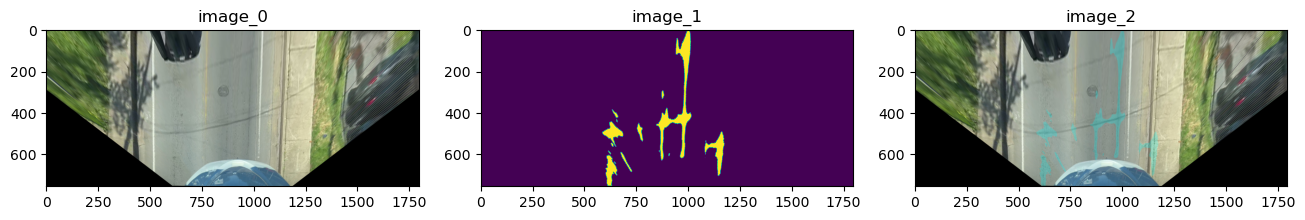

In [ ]:
plot(
    [
        image,
        mask,
        bin_mask_overlay(image, mask, mask_color=Color.CYAN, transparency=0.75),
    ],
    max_col_width=0.33,
    max_row_height=1,
)

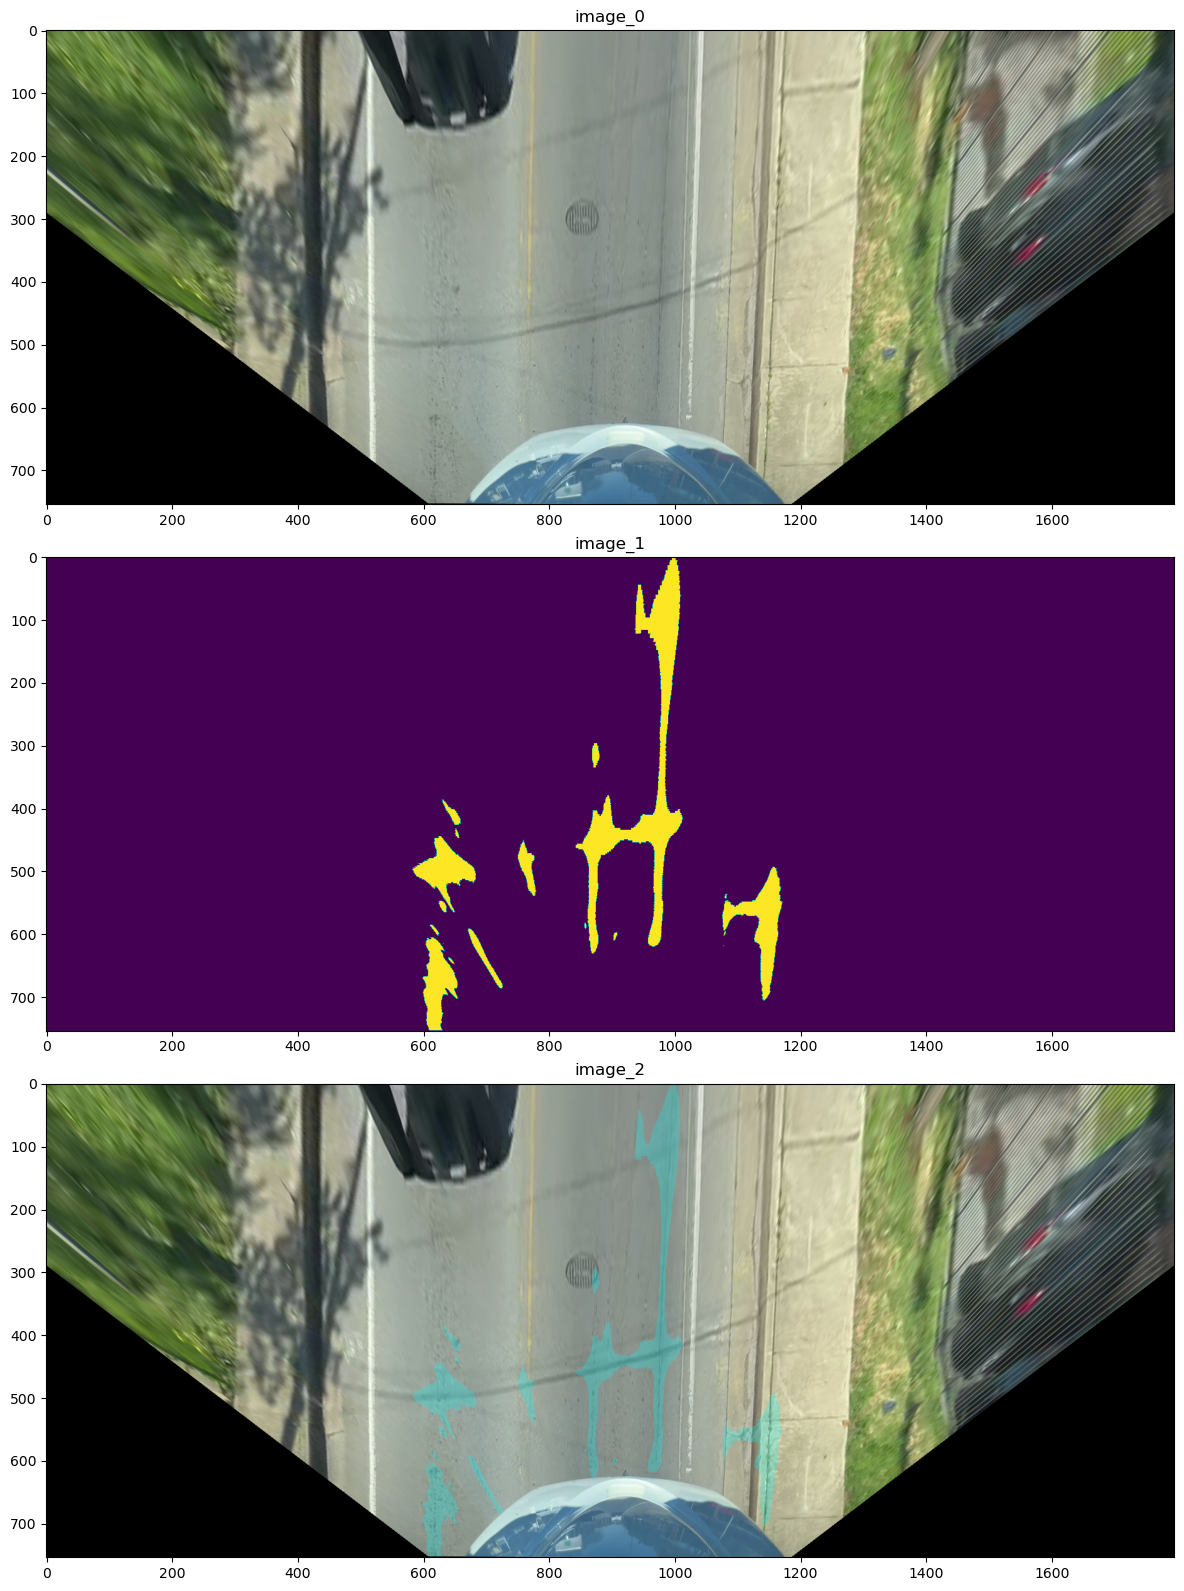

In [ ]:
plot(
    [
        image,
        mask,
        bin_mask_overlay(image, mask, mask_color=Color.CYAN, transparency=0.75),
    ],
    max_col_width=1,
    max_row_height=1,
)

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()